<a href="https://colab.research.google.com/github/faisalrasbihan/gru-momentum-clean-slate/blob/master/gru10_clean_slate_REGRESSION_closing_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preamble

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from numpy import ones,vstack
from numpy.linalg import lstsq
import missingno as msno
from tqdm import tqdm

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Conv1D, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

# Data Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from itertools import combinations_with_replacement 
import multiprocessing

# Math & Stats
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score
from scipy import stats

sns.set()

# 1. Import Data

In [2]:
# Read CSV - LQ45 Historical Data
df = pd.read_csv('LQ45_20210309.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.set_index('Date').sort_index().rename(columns={"Price": "Close"})
df.drop(['LQ45_Vol'],axis=1,inplace=True)

# read IDX30 data
IDX30 = pd.read_csv('IDX30_20210309.csv').rename(columns={"IDX30_Vol": "Volume"})
IDX30['Date'] = pd.to_datetime(IDX30['Date'], format='%d/%m/%Y')
IDX30 = IDX30.set_index('Date').sort_index().rename(columns={"Price": "IDX30"})

# read IHSG data
IHSG = pd.read_csv('IHSG_20210309.csv')
IHSG['Date'] = pd.to_datetime(IHSG['Date'], format='%d/%m/%Y')
IHSG = IHSG.set_index('Date').sort_index().rename(columns={"Price": "IHSG"})

IDX30.replace(0, np.nan, inplace=True)
IDX30['Volume'] = IDX30['Volume']/1000000000
IDX30.loc[IDX30.Volume > 13, 'Volume'] = np.nan

IDX30 = IDX30[['IDX30','Volume']]
IHSG = IHSG[['IHSG']]

# read EIDO data
EIDO = pd.read_csv('EIDO_20210309.csv')
EIDO['Date'] = pd.to_datetime(EIDO['Date'], format='%d/%m/%Y')
EIDO = EIDO.set_index('Date').sort_index().rename(columns={"Price": "EIDO"})

# read SPY data
SPY = pd.read_csv('SPY_20210309.csv')
SPY['Date'] = pd.to_datetime(SPY['Date'], format='%d/%m/%Y')
SPY = SPY.set_index('Date').sort_index().rename(columns={"Price": "SPY"})

# read JCI data
jci_value = pd.read_csv('JCI_value.csv')
jci_value['date'] = pd.to_datetime(jci_value['date'], format='%d/%m/%Y')
jci_value = jci_value.set_index('date').sort_index()

SPY = SPY[['SPY']]#.resample('D').mean().shift(1).fillna(method='ffill')
EIDO = EIDO[['EIDO']]#.resample('D').mean().shift(1).fillna(method='ffill')

In [3]:
# Merge dataset
df = df.merge(SPY, how='outer', left_index=True, right_index=True).copy()
df = df.merge(EIDO, how='outer', left_index=True, right_index=True).copy()
df = df.merge(IHSG, how='left', left_index=True, right_index=True).copy()
df = df.merge(IDX30, how='left', left_index=True, right_index=True).copy()
df = df.merge(jci_value[['for_flow','dom_total','tot_buy']], how='left', left_index=True, right_index=True).copy()

# 2. Helper Functions

In [4]:
def sign_accuracy(true,pred):
    true = (true*STD) + MEAN
    pred = (pred*STD) + MEAN
    return K.mean(K.equal(K.sign(true), K.sign(pred)))

In [5]:
def generate_prediction(m, X, y, dates=dt.datetime(2012, 5, 1)):
    pred = m.predict(X)[:,0]
    true = y[:,0]
    train_result = pd.DataFrame()
    train_result['true_bin'] = np.where(true < 0, -1, 1)
    train_result['pred_bin'] = np.where(pred < 0, -1, 1)
    train_result['true']  = true
    train_result['pred'] = pred
    train_result['mse'] = np.abs(train_result['true'] - train_result['pred']).rolling(7).sum()
    train_result['squared_hinge'] = 1 - train_result['true'] * train_result['pred']
    train_result.loc[train_result['squared_hinge'] < 0,'squared_hinge'] = 0
    train_result['squared_hinge'] = train_result['squared_hinge']**2
    train_result['rolling_error'] = train_result['squared_hinge'].rolling(7).mean()
    train_result['date'] = dates
    train_result['date_str'] = train_result['date'].dt.strftime('%Y-%m-%d')
    train_result['date_to_val'] = train_result['date'].map(pd.Series(data=np.arange(len(train_result)), 
                                                                     index=train_result['date'].values).to_dict())
    return pred,true,train_result

In [6]:
def create_model(neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(neurons, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dense(output_timesteps, activation='linear'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [7]:
def multi_gru_model(neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(50, return_sequences=True, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dropout(0.2))
    model.add(GRU(50, activation='linear'))
    model.add(Dropout(0.2))
    model.add(Dense(output_timesteps, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [8]:
def multi_layer_model(gru_neurons,hidden_neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(gru_neurons, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dense(hidden_neurons, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [9]:
MEAN_pre_filtered = 0.06968521192214656
STD_pre_filtered = 2.3073312870270306

def target_inverse_transform(x, mean=MEAN_pre_filtered, std=STD_pre_filtered):
    return (x*STD) + MEAN

def target_transform(x, mean=MEAN_pre_filtered, std=STD_pre_filtered):
    return (x - MEAN)/STD

In [10]:
def train_test_date_split(df_orig, range1='2020-01-01', range2='2019-01-01', range3='2020-01-01', range4='2021-02-01'):
    df = df_orig.copy()
    df_train = df[(df.index < range1)].copy()
    df_test = df[(df.index >= range2) & (df.index < range3)].copy()
    df_test2 = df[(df.index >= range3) & (df.index < range4)].copy()
    return df_train, df_test, df_test2

In [11]:
def hampel(vals_orig, k=7, t0=3):
    #Make copy so original not edited
    vals = vals_orig.copy()
    
    #Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)
    
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    return outlier_idx, vals

In [12]:
def generate_batch(data, input_timesteps, output_timesteps,input_variables, output_variables):
    '''
    Inputs a dataframe with desired sequence length and target name
    Yield a generator of training data from filename on given list of cols split for train/test
    outputs Sequence of data with corresponding target
    '''
    X, y = list(), list()
    target = data[output_variables].values
    data = data[input_variables].values
    # Iterate 
    for i in range(len(data) - (input_timesteps + output_timesteps) + 1):
        end_seq_x = i + input_timesteps
        end_seq_y = end_seq_x + output_timesteps
        # Input sequence starts from i to (i + input_timesteps - 1)
        seq_x = data[i:end_seq_x]
        # Target sequence starts after end of input sequence to end_ix + output_timesteps
        seq_y = target[end_seq_x:end_seq_y]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
def display_confusion_matrix(conf_matrix, reverse_ylabel=False, reverse_xlabel=False):
    labels = ['Negatives','Positives']
    sns.heatmap(conf_matrix, 
                annot=True, 
                cmap="Blues",
                fmt="d",vmin=0, 
                annot_kws={"size": 20}, 
                xticklabels = labels[::-1] if reverse_xlabel else labels, 
                yticklabels= labels[::-1] if reverse_ylabel else labels)
    plt.xlabel('Predicted Values', fontsize = 12) # x-axis label with fontsize 15
    plt.ylabel('Actual Values', fontsize = 12) # y-axis label with fontsize 15
    plt.show()

# 3. Feature Engineering

In [14]:
# Filter volume
outlier_idx, dom_filtered = hampel(df.dom_total,k=20,t0=9)
dom_outlier = df.dom_total.copy()
dom_outlier[~outlier_idx] = np.nan
df['dom_filtered'] = dom_filtered

outlier_idx, for_filtered = hampel(df.for_flow,k=20,t0=9)
for_outlier = df.for_flow.copy()
for_outlier[~outlier_idx] = np.nan
df['for_flow_filtered'] = for_filtered

outlier_idx, total_buy_filtered = hampel(df.tot_buy,k=20,t0=9)
tot_outlier = df.tot_buy.copy()
tot_outlier[~outlier_idx] = np.nan
df['total_buy_filtered'] = total_buy_filtered

In [15]:
# Resample Date to fill missing date
df = df.resample('D').mean()

# Interpolate Close and Volume Values
df.interpolate(inplace=True)

# Remove saturday and sunday data
df['day_of_week'] = df.index.dayofweek + 1
df = df[df['day_of_week'] < 6].copy()
df.drop(columns=['day_of_week'],inplace=True)

df = df[df.index >= '2012-04-24'].copy()

## 3.3 Create Engineered Features

In [16]:
MA_PERIOD = 5
FUTURE_DAYS = 1

df['momentum'] = df['Close'] - df['Close'].rolling(window=MA_PERIOD).mean()
# df['price_volatility'] = df['1day_price_change'].rolling(10).std()
df['linear_series'] = (df.reset_index().index + 1000) / 1000
# df['target'] = df['Close'].pct_change(periods=FUTURE_DAYS).shift(-(FUTURE_DAYS)) * 100
df['target'] = df['Close'].shift(-FUTURE_DAYS)

df['EIDO'] = 100*df['EIDO']/df['EIDO'][0]
df['SPY'] = 100*df['SPY']/df['SPY'][0]
df['EIDO_SPY_diff'] = df['EIDO'] - df['SPY']
df['EIDO_SPY_ma'] = df['EIDO_SPY_diff'].rolling(7).mean()

df['IDX30'] = 100*df['IDX30']/df['IDX30'][0]
df['IHSG'] = 100*df['IHSG']/df['IHSG'][0]
df['IDX30_IHSG_diff'] = df['IDX30'] - df['IHSG']
df['IDX30_IHSG_ma'] = df['IDX30_IHSG_diff'].rolling(7).mean()

df['dom_filtered'] = df['dom_filtered'] / (10**6)
df['for_flow_filtered'] = df['for_flow_filtered'] / (10**6)
df['total_buy_filtered'] = df['total_buy_filtered']/(10**6)

df['dom_val_ma'] = df['dom_filtered'].rolling(7).mean()
df['for_flow_ma'] = df['for_flow_filtered'].rolling(7).mean()
df['total_val_grad'] = df['total_buy_filtered'].rolling(3).mean() - df['total_buy_filtered'].rolling(11).mean().shift(3)

In [17]:
df[['Close','target']].head(20)

,Close,target
Date,,
2012-04-24,709.970,708.000
2012-04-25,708.000,712.200
2012-04-26,712.200,708.390
2012-04-27,708.390,711.380
2012-04-30,711.380,714.420
2012-05-01,714.420,718.510
2012-05-02,718.510,717.780
2012-05-03,717.780,716.220
2012-05-04,716.220,706.730


## 3.1 Remove outliers on target

In [18]:
# # Remove outliers
# df = df[(df['target'] < 3*STD_pre_filtered) & (df['target'] > -3*STD_pre_filtered)]

# Determine mean and standard deviation
MEAN = np.nanmean(df['target'].values)
STD = np.nanstd(df['target'].values)
print('Mean: ', MEAN)
print('STD: ', STD)

# Plot result
fig = px.histogram(df, x="target",
                   marginal="box", # or violin, rug
                   hover_data=df.columns)
fig.show()


Mean:  871.4792183677746
STD:  107.2776169151246


In [19]:
# # Determine 33% and 66% quartile from target
# quantile_33 = np.quantile(df['target'], 0.33)
# quantile_66 = np.quantile(df['target'], 0.66)

# # Set target at 0 for 33-66% quantile
# mask = (df.target > quantile_33) & (df.target < quantile_66)
# df.loc[mask, 'target'] = 0

# # Plot result
# fig = px.histogram(df, x="target",
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)
# fig.show()

# 4. Train Model

In [20]:
slow_and_fast = [(6,6),(7,5),(8,4),(9,3),(9,7),(10,6),(8,6),(9,5),(10,4),(11,3)]
combi = list(combinations_with_replacement(slow_and_fast,3))
highacc_combi = list(combi[i] for i in [4, 14, 21, 28])
highacc_combi

[((6, 6), (6, 6), (9, 7)),
 ((6, 6), (7, 5), (10, 6)),
 ((6, 6), (8, 4), (9, 7)),
 ((6, 6), (9, 3), (9, 7))]

In [21]:
target_variables = 'target'
input_variables = ['momentum','IDX30_IHSG_grad','EIDO_SPY_grad','total_val_grad','dom_val_ma','for_flow_ma','Close']
neurons = 90
multi_neurons = (20,5)
loss = 'mse'
input_timesteps = 20
output_timesteps = 1
epochs = 180
validation_split = 0.2
span = 4
d = highacc_combi[1]

In [22]:
# Final Variables
df2 = df.copy()
df2['momentum'] = df['Close'] - df['Close'].rolling(window=span).mean()
df2['EIDO_SPY_grad'] = df2['EIDO_SPY_diff'].rolling(d[0][1]).mean() - df2['EIDO_SPY_diff'].rolling(d[0][0]).mean().shift(d[0][1])
df2['IDX30_IHSG_grad'] = df2['IDX30_IHSG_diff'].rolling(d[1][1]).mean() - df2['IDX30_IHSG_diff'].rolling(d[1][0]).mean().shift(d[1][1])
df2['Volume_grad'] = df2['Volume'].rolling(d[2][1]).mean() - df2['Volume'].rolling(d[2][0]).mean().shift(d[2][1])

df2['Close'] = df2['Close'].apply(target_transform, mean=MEAN, std=STD) # Standardize target with predetermined constants
df2['target'] = df2['target'].apply(target_transform, mean=MEAN, std=STD) # Standardize target with predetermined constants

In [23]:
#plot_all

In [24]:
# Train test split
df2 = df2.dropna()

# Final Sanity Check
df2[(df2.index > '2020-11-09')][input_variables + [target_variables]]

,momentum,IDX30_IHSG_grad,EIDO_SPY_grad,total_val_grad,dom_val_ma,for_flow_ma,Close,target
Date,,,,,,,,
2020-11-10,25.0850,1.511065,-5.912682,3.667802,14.928623,0.458449,-0.069998,0.079614
2020-11-11,25.1700,2.865765,-7.573640,5.519832,16.853821,0.817652,0.079614,-0.044736
2020-11-12,3.8850,3.459608,-7.502549,5.160973,17.506280,0.894226,-0.044736,-0.039889
2020-11-13,-2.2675,3.678325,-6.139579,2.188416,17.629074,0.859133,-0.039889,0.018278
2020-11-16,1.6050,3.754625,-5.741578,-0.638807,17.588039,0.704874,0.018278,0.096300
...,...,...,...,...,...,...,...,...
2021-03-01,13.7875,0.008931,2.905305,3.835739,21.814481,0.173242,0.897119,0.896560
2021-03-02,9.4925,-0.063408,2.634660,3.275145,22.194230,0.175230,0.896560,0.901780
2021-03-03,6.1325,-0.047181,2.574614,-0.710991,21.479434,0.193781,0.901780,0.717678


In [25]:
df_train = df2[(df2.index < '2019-01-01')].copy()
df_test = df2[(df2.index >= '2019-01-01') & (df2.index <= '2020-02-01')].copy()
df_test2 = df2[(df2.index >= '2020-01-01') & (df2.index <= '2021-02-01')].copy()
df_test3 = df2[(df2.index >= '2020-01-01') & (df2.index <= '2021-02-01')].copy()

# Unroll data
dates = df_train[(input_timesteps+output_timesteps-1):].index

# Separate train and test data
X_train, y_train = generate_batch(df_train, input_timesteps, output_timesteps, input_variables, target_variables)
######### DELETE LATER #########
lower_thresh = np.quantile(y_train, 0.4)
upper_thresh = np.quantile(y_train, 0.6)
# mask = (y_train < lower_thresh) | (y_train > upper_thresh)
# X_train = X_train[mask[:,0]]
# y_train = y_train[mask[:,0]]
######### DELETE LATER #########
X_test, y_test = generate_batch(df_test, input_timesteps, output_timesteps, input_variables, target_variables)
X_test2, y_test2 = generate_batch(df_test2, input_timesteps, output_timesteps,  input_variables, target_variables)
X_test3, y_test3 = generate_batch(df_test3, input_timesteps, output_timesteps,  input_variables, target_variables)

# Build LSTM Model using Tensorflow
model = create_model(neurons, output_timesteps, X_train.shape[1], X_train.shape[2], loss)
# model = multi_layer_model(multi_neurons[0],multi_neurons[1],output_timesteps,X_train.shape[1], X_train.shape[2],loss)
# model = multi_layer_model(multi_neurons[0],multi_neurons[1],output_timesteps,X_train.shape[1], X_train.shape[2],loss)

model_name = 'gru7_oneoff_n{neurons}_{feature_count}var_span{span}_X1.hdf5'.format(
                                                                                neurons=neurons,
                                                                                span=span,
                                                                                feature_count=len(input_variables))
model_path = 'temp_model/{}'.format(model_name)
mcp_save = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min',verbose=2)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=len(X_train),
    validation_split=validation_split,
    verbose = 2, 
    shuffle=True,
    callbacks=[mcp_save]
)

new_model = tf.keras.models.load_model(model_path, compile=False)

Epoch 1/180
1/1 - 2s - loss: 3.6271 - sign_accuracy: 1.0000 - val_loss: 1.4494 - val_sign_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 1.44943, saving model to temp_model/gru7_oneoff_n90_7var_span4_X1.hdf5
Epoch 2/180
1/1 - 0s - loss: 1.9653 - sign_accuracy: 1.0000 - val_loss: 1.7249 - val_sign_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 1.44943
Epoch 3/180
1/1 - 0s - loss: 1.0515 - sign_accuracy: 1.0000 - val_loss: 2.8949 - val_sign_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 1.44943
Epoch 4/180
1/1 - 0s - loss: 0.7491 - sign_accuracy: 1.0000 - val_loss: 4.2490 - val_sign_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 1.44943
Epoch 5/180
1/1 - 0s - loss: 0.8090 - sign_accuracy: 1.0000 - val_loss: 5.0451 - val_sign_accuracy: 1.0000

Epoch 00005: val_loss did not improve from 1.44943
Epoch 6/180
1/1 - 0s - loss: 0.9264 - sign_accuracy: 1.0000 - val_loss: 5.0495 - val_sign_accuracy: 1.0000

Epoch 00006: val_loss did not impr

In [26]:
# plot training history
hist = pd.DataFrame.from_dict(history.history)
# fig = go.Figure()

fig = make_subplots(rows=1, 
                    cols=2,
                    subplot_titles=("Train and Validation Loss per epoch", "Train and Validation Accuracy per epoch"))

# Plot Train and Validation Loss per epoch
fig.add_trace(go.Scatter(y=hist['loss'],
                         line=dict(color='blue')
                         ,name='train_loss'),
    row=1, col=1)
fig.add_trace(go.Scatter(y=hist['val_loss'],
                         line=dict(color='firebrick'),
                         name='val_loss'),
    row=1, col=1)

# Plot Train and Validation Accuracy per epoch
fig.add_trace(go.Scatter(y=hist['sign_accuracy'],
                         line=dict(color='blue'),
                         name='train'),
    row=1, col=2)
fig.add_trace(go.Scatter(y=hist['val_sign_accuracy'],
                         line=dict(color='firebrick'),
                         name='val'),
    row=1, col=2)

# Set x and y axes title
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)

fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Accuracy", row=1, col=2)


fig.show()

In [27]:
# Train-test target distributions
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=df_train['target']))
# fig.add_trace(go.Histogram(x=df_test['target']))
# fig.show()

# 5. Evaluate Model

In [28]:
# Generate result from model
_,_,train_result = generate_prediction(new_model,X_train,y_train,dates=df_train[(input_timesteps+output_timesteps-1):].index)
_,_,test_result = generate_prediction(new_model,X_test,y_test,df_test.index[(input_timesteps+output_timesteps-1):])
_,_,test_result2 = generate_prediction(new_model,X_test2,y_test2,df_test2.index[(input_timesteps+output_timesteps-1):])
_,_,test_result3 = generate_prediction(new_model,X_test3,y_test3,df_test3.index[(input_timesteps+output_timesteps-1):])

## 5.1 Train Result Evaluation

In [29]:
train_result.tail(20)

,true_bin,pred_bin,true,pred,mse,squared_hinge,rolling_error,date,date_str,date_to_val
1690,1,1,1.006461,1.093531,0.779342,0.000000,0.040349,2018-12-04,2018-12-04,1690
1691,1,1,0.983344,1.204558,0.910401,0.000000,0.032572,2018-12-05,2018-12-05,1691
1692,1,1,0.989123,1.219474,1.025997,0.000000,0.018166,2018-12-06,2018-12-06,1692
1693,1,1,0.964887,1.142220,1.038455,0.000000,0.013354,2018-12-07,2018-12-07,1693
1694,1,1,0.911847,1.086538,1.128043,0.000085,0.001231,2018-12-10,2018-12-10,1694
1695,1,1,0.967404,0.956496,1.115481,0.005577,0.001953,2018-12-11,2018-12-11,1695
1696,1,1,1.078890,0.894635,1.085822,0.001210,0.000982,2018-12-12,2018-12-12,1696
1697,1,1,1.073577,0.925634,1.146695,0.000039,0.000987,2018-12-13,2018-12-13,1697
1698,1,1,0.929185,1.043314,1.039610,0.000934,0.001121,2018-12-14,2018-12-14,1698
1699,1,1,0.925270,1.053422,0.937411,0.000640,0.001212,2018-12-17,2018-12-17,1699


In [30]:
df[(df.index >= '2018-12-04') & (df.index <= '2018-12-31')].Close

Date
2018-12-04    985.960
2018-12-05    979.450
2018-12-06    976.970
2018-12-07    977.590
2018-12-10    974.990
2018-12-11    969.300
2018-12-12    975.260
2018-12-13    987.220
2018-12-14    986.650
2018-12-17    971.160
2018-12-18    970.740
2018-12-19    990.630
2018-12-20    985.060
2018-12-21    989.180
2018-12-24    983.702
2018-12-25    981.876
2018-12-26    980.050
2018-12-27    988.000
2018-12-28    982.730
2018-12-31    983.702
Name: Close, dtype: float64

In [31]:
train_result['true'] = train_result['true'].apply(target_inverse_transform, mean=MEAN, std=STD)
train_result['pred'] = train_result['pred'].apply(target_inverse_transform, mean=MEAN, std=STD)

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_result.date, y=train_result.true,
                    mode='lines',
                    name='true'))
fig.add_trace(go.Scatter(x=train_result.date, y=train_result.pred,
                    mode='lines',
                    name='pred'))
fig.show()

In [32]:
train_result
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_result.date, y=train_result.true,
                    mode='lines',
                    name='true'))
fig.add_trace(go.Scatter(x=test_result.date, y=train_result.pred,
                    mode='lines',
                    name='pred'))
fig.show()

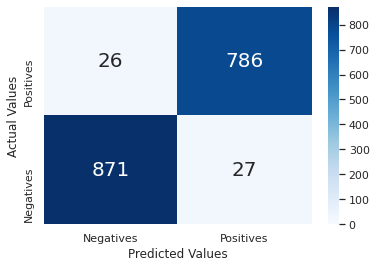

In [33]:
conf_matrix = confusion_matrix(train_result['true_bin'], train_result['pred_bin'])[::-1]
display_confusion_matrix(conf_matrix, reverse_ylabel=True)

In [34]:
print(classification_report(train_result['true_bin'],train_result['pred_bin'], target_names=['Negatives','Positives']))

              precision    recall  f1-score   support

   Negatives       0.97      0.97      0.97       898
   Positives       0.97      0.97      0.97       812

    accuracy                           0.97      1710
   macro avg       0.97      0.97      0.97      1710
weighted avg       0.97      0.97      0.97      1710



In [35]:
fig = px.scatter(train_result, x="pred", y="true", color="squared_hinge", 
                 trendline="ols",
                 title="Train Result",
                 width=800, height=800, hover_data=["date_str"])
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## 5.2 Test Result Evaluation

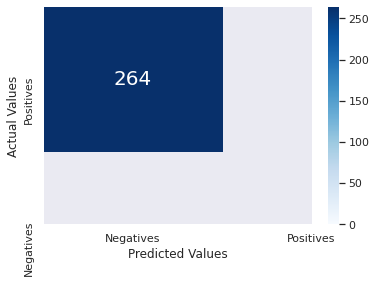

In [36]:
conf_matrix2 = confusion_matrix(test_result['true_bin'],test_result['pred_bin'])[::-1]
display_confusion_matrix(conf_matrix2, reverse_ylabel=True)

In [37]:
print(classification_report(test_result['pred_bin'], test_result['true_bin'], target_names=['Negatives','Positives']))

ValueError: ignored

In [ ]:
test_pred_ter = np.where(test_result['pred'] < lower_thresh,-1,np.where(test_result['pred'] > upper_thresh,1,0))
test_true_ter = np.where(test_result['true'] < lower_thresh,-1,np.where(test_result['true'] > upper_thresh,1,0))
conf_matrix = confusion_matrix(test_true_ter,test_pred_ter)[::-1]
labels = ['Negatives','Hold','Positives']
sns.heatmap(conf_matrix, 
                annot=True, 
                cmap="Blues",
                fmt="d",vmin=0, 
                annot_kws={"size": 20}, 
                xticklabels = labels, 
                yticklabels= labels[::-1])
plt.xlabel('Predicted Values', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Actual Values', fontsize = 12)

In [ ]:
fig = px.scatter(test_result, x="pred", y="true", color="squared_hinge", 
                 trendline="ols",
                 title="Test Result",
                 width=800, height=800, hover_data=["date_str"])
fig.show()